In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize (optional)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Check dataset shape
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10 dataset
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [-1, 1] (better for GANs)
x_train = (x_train - 127.5) / 127.5
x_train = x_train.astype('float32')

# Shape check
print(f"Dataset shape: {x_train.shape}")


Dataset shape: (50000, 32, 32, 3)


In [ ]:
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, activation="relu", input_shape=(100,)),
        Reshape((8, 8, 256)),

        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, kernel_size=4, strides=1, padding="same", activation="tanh")
    ])
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,411 (8.82 MB)

 Trainable params: 2,313,411 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation="sigmoid")  # Outputs probability (real/fake)
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,529 (556.75 KB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile Discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002), metrics=["accuracy"])

# Make the Discriminator non-trainable while training the Generator
discriminator.trainable = False

# GAN Model: Stacks Generator + Discriminator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def build_gan(generator, discriminator):
    noise_input = Input(shape=(100,))
    generated_image = generator(noise_input)
    gan_output = discriminator(generated_image)

    model = Model(noise_input, gan_output)
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002))
    return model

gan = build_gan(generator, discriminator)
gan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 32, 32, 3)           │       2,313,411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         142,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,455,940 (9.37 MB)

 Trainable params: 2,313,411 (8.82 MB)

 Non-trainable params: 142,529 (556.75 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss=0.6881014108657837, G Loss=0.6948323249816895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


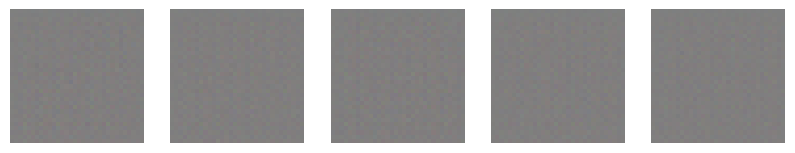

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import time

def train_gan(epochs=10000, batch_size=128):
    real_images = x_train
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, real_images.shape[0], half_batch)
        real_samples = real_images[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_samples = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator (via GAN model)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: D Loss={d_loss[0]}, G Loss={g_loss}")
            generate_images(epoch)

# Function to visualize generated images
def generate_images(epoch, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))
    fake_images = generator.predict(noise)
    fake_images = 0.5 * fake_images + 0.5

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(fake_images[i])
        axes[i].axis("off")
    plt.show()

# Train the GAN
train_gan(epochs=1000, batch_size=128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


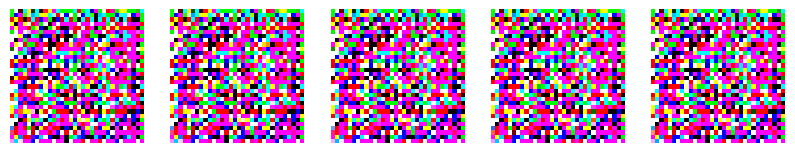

In [ ]:
# Generate new images
noise = np.random.normal(0, 1, (10, 100))
fake_images = generator.predict(noise)
fake_images = 0.5 * fake_images + 0.5

# Show generated images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_images[i])
    axes[i].axis("off")
plt.show()


In [ ]:
import numpy as np

# Generate fake images using trained Generator
def generate_fake_images(num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 100))
    fake_images = generator.predict(noise)
    fake_images = 0.5 * fake_images + 0.5  # Rescale to [0,1]
    return fake_images

# Create fake dataset
fake_images = generate_fake_images(50000)
real_images = x_train[:50000]  # Take first 50,000 real images

# Labels: 1 for real, 0 for fake
real_labels = np.ones((real_images.shape[0], 1))
fake_labels = np.zeros((fake_images.shape[0], 1))

# Combine real & fake data
X = np.vstack((real_images, fake_images))
y = np.vstack((real_labels, fake_labels))

# Shuffle dataset
from sklearn.utils import shuffle
X, y = shuffle(X, y)

print(f"Dataset prepared! Shape: {X.shape}, Labels: {y.shape}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 301s 192ms/step
Dataset prepared! Shape: (100000, 32, 32, 3), Labels: (100000, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN Model
def build_classifier():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Binary classification (real/fake)
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create classifier
classifier = build_classifier()
classifier.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,265 (2.42 MB)

 Trainable params: 634,369 (2.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Train the classifier
classifier.fit(X, y, epochs=100, batch_size=128, validation_split=0.2)


Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 384s 608ms/step - accuracy: 0.9936 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 6.6063e-08
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 382s 608ms/step - accuracy: 1.0000 - loss: 2.9605e-07 - val_accuracy: 1.0000 - val_loss: 2.9906e-08
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 373s 593ms/step - accuracy: 1.0000 - loss: 8.2379e-08 - val_accuracy: 1.0000 - val_loss: 1.8794e-08
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 382s 593ms/step - accuracy: 1.0000 - loss: 4.2951e-08 - val_accuracy: 1.0000 - val_loss: 1.0128e-08
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 387s 601ms/step - accuracy: 1.0000 - loss: 2.7280e-08 - val_accuracy: 1.0000 - val_loss: 6.9422e-09
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 380s 598ms/step - accuracy: 1.0000 - loss: 1.7913e-08 - val_accuracy: 1.0000 - val_loss: 3.7724e-09
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 381s 597ms/step - accuracy: 1.0000 - loss: 1.4116e-08 - val_accuracy: 1.0000 - val_loss: 3.2471e-09
Epoch 8/100
625/6

In [ ]:
# Generate new fake images for testing
fake_test_images = generate_fake_images(1000)
real_test_images = x_test[:1000]

# Labels
real_test_labels = np.ones((real_test_images.shape[0], 1))
fake_test_labels = np.zeros((fake_test_images.shape[0], 1))

# Combine test data
X_test = np.vstack((real_test_images, fake_test_images))
y_test = np.vstack((real_test_labels, fake_test_labels))

# Shuffle test set
X_test, y_test = shuffle(X_test, y_test)

# Evaluate model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 4.2527e-10
Test Accuracy: 100.00%


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def classify_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (32, 32))  # Resize to 32x32 (same as training data)

    # Normalize the image (same as during training)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = classifier.predict(img)[0][0]

    # Display image
    plt.imshow(img[0])
    plt.axis("off")

    # Show result
    if prediction > 0.5:
        print(" The image is REAL!")
    else:
        print(" The image is FAKE!")

    plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will open a file upload dialog


Saving car.jpg to car.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
🟢 The image is REAL!


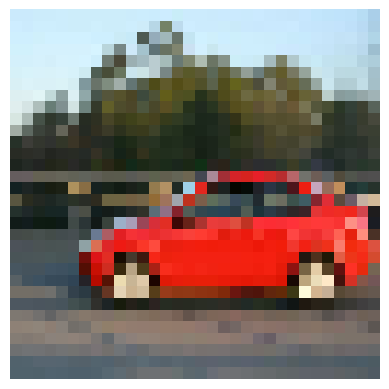

In [ ]:
classify_image("car.jpg") # Replace with your actual file name
